In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint

In [2]:
## B-spline class

class Bspline():
    
    def __init__(self, order, knots):
        
        self.knots = tf.constant(knots, dtype = tf.float32)
        self.order = order
        self.degree = order - 1
        self.num_params = len(knots) - order

    def bspline_basis(self, x, k, i, t):
        """
        B-spline basis function value B(j,n) at x.
        
        Input arguments:
         x:
            value where the basis function is to be evaluated
         n:
            B-spline order (2 for linear, 1 for quadratic, etc.)
         i:
            interval index, 0 =< j < numel(t)-k-1

         t:
            knot vector

         Output arguments:
         y:
        
        """
        if k == 0:

            return 1.0 if t[i] <= x < t[i+1] else 0.0

        if t[i+k] == t[i]:

            c1 = 0.0 #indeterminate forms 0/0 are deemed to be zero

        else:
            
            c1 = (x - t[i])/(t[i+k] - t[i]) * self.bspline_basis(x, k-1, i, t)

        if t[i+k+1] == t[i+1]:

            c2 = 0.0 #indeterminate forms 0/0 are deemed to be zero

        else:

            c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * self.bspline_basis(x, k-1, i+1, t)
        
        return c1 + c2
    
    def basis_matrix(self, x):
        """
        B-spline basis function value matrix B(n) for x.
        
        Input arguments:
         n:
            B-spline order (2 for linear, 3 for quadratic, etc.)
         t:
            knot vector
         x (optional):
            an m-dimensional vector of values where the basis function is to be
            evaluated
        
        Output arguments:
         B:
            a matrix of m rows and numel(t)-n columns
        """
        n = self.order
        t = self.knots
        k = n-1
        
        B = np.zeros((len(x),len(t) - n))
        
        for i in range(len(t) - n):
            for j in range(len(x)):
                B[j,i] = self.bspline_basis(x[j], k, i, t)
            
        return tf.constant(B, dtype = tf.float32)      
        
    def fit(self, x_data, y_data):
        
        x_data = tf.constant(x_data, dtype = tf.float32)
        y_data = tf.constant(y_data, dtype = tf.float32)
        
        Bmat =  self.basis_matrix(x_data)
        
        #Solve least squares y = B * c
        self.coeffs = tf.linalg.lstsq(Bmat, y_data)
    
    def predict(self, x_pred, coeffs = None):
        
        if coeffs is None:
            coeffs = self.coeffs
        
        x_pred = tf.constant(x_pred, dtype = tf.float32)
        coeffs = tf.constant(coeffs, dtype = tf.float32)
        
        Bmat =  self.basis_matrix(x_pred)
        
        y_pred = tf.matmul(Bmat, coeffs)
        
        return y_pred

In [3]:
from itertools import chain, combinations
from itertools import combinations_with_replacement as combinations_w_r
from math import comb

class DynamicsBasis():
    
    def __init__(self, degree, X, t):  
#         super().__init__(degree = degree)
        self.m_samples = X.shape[0]
        self.dim = X.shape[1]
        self.degree = degree
        self.n_basis = comb(self.dim + self.degree, self.degree)
        self.t = t
        self.include_bias = True
        self.X = tf.constant(X, dtype = tf.float32)
        
    @property
    def multi_index(self):
        
        comb = combinations_w_r
        start = int(not self.include_bias)
        combinations = chain.from_iterable(comb(range(self.dim), i) for i in range(start, self.degree + 1))
                                   
        
        return tf.cast(tf.stack([tf.math.bincount(c, minlength=self.dim) for c in combinations], axis = 0), dtype = tf.float32)
                                    
    @property
    def basis_names(self, input_dims = None):
        
        powers = self.multi_index.numpy()
        if input_dims is None:
            input_dims = ['x%d' % i for i in range(powers.shape[1])]
        basis_names = []
        for row in powers:
            inds = np.where(row)[0]
            if len(inds):
                name = " ".join("%s^%d" % (input_dims[ind], exp)
                                if exp != 1 else input_dims[ind]
                                for ind, exp in zip(inds, row[inds]))
            else:
                name = "1"
            basis_names.append(name)
            
        return basis_names
    
    def phi_matrix(self, X = None):
        
        if X is None:
            X = self.X
        else:
            X = tf.constant(X, dtype = tf.float32)
            
        
        powers = self.multi_index
        
        Phi = tf.zeros((X.shape[0], self.n_basis))
        
#         idx_arr = np.zeros((X.shape[0],2))
#         idx_arr[:,0] = [i for i in range(X.shape[0])]
        
#         for basis in range(self.n_basis):
            
#             idx_arr[:,1] = basis
#             indices = tf.convert_to_tensor(idx_arr, dtype = tf.int32)
#             print(indices)
#             updates = tf.reduce_prod(tf.pow(X, tf.tile([powers[basis,:]],[X.shape[0],1])), axis = 1)
#             print(updates)
#             tf.tensor_scatter_nd_update(Phi, indices, updates)

        for basis in range(self.n_basis):
        
            indices = tf.constant([basis])
            col_indices_nd = tf.stack(tf.meshgrid(tf.range(tf.shape(Phi)[0]), indices, indexing='ij'), axis=-1)
            updates = tf.reshape(tf.reduce_prod(tf.pow(X, tf.tile([powers[basis,:]],[X.shape[0],1])), axis = 1), (X.shape[0],1))
            
            temp = tf.scatter_nd(col_indices_nd, updates, (X.shape[0], self.n_basis))
            Phi = tf.add(Phi, temp)
            
        return Phi
        
    def psi_matrix(self, X=None, t=None):
        
        if X is None:
            X = self.X
        else:
            X = tf.constant(X, dtype = tf.float32)
            
        if t is None:
            t = self.t
        else:
            t = tf.constant(t, dtype = tf.float32)
        
        Dt = t[1] - t[0]
                
        T = tf.constant(Dt * np.tril(np.ones(X.shape[0])), dtype = tf.float32)
        
        Phi = self.phi_matrix(X)
                
        return tf.matmul(T, Phi)

In [4]:
class SRSplineIdentification():
    
    def __init__(self, X, t, poly_degree = 4, spline_order = 4):
        
        self.t = tf.constant(t, dtype = tf.float32)
        self.m_samples = X.shape[0]
        self.dim = X.shape[1]
        self.Y_data = tf.constant(np.reshape(X,(self.dim * self.m_samples, 1),'F'), dtype = tf.float32)

        knots = np.concatenate([[t[0]]*3, t, [t[-1]]*3])
        self.bspline = Bspline(spline_order, knots)#Initialize bspline object
        bspmat = tf.constant(self.bspline.basis_matrix(t), dtype = tf.float32)
        self.spline_matrix = self.blockdiag_tensor(bspmat)
        
        t_half = 0.5 * (t[1:] + t[0:-1])
        self.t_half = tf.constant(t_half, dtype = tf.float32)
        bspmat_half = tf.constant(self.bspline.basis_matrix(t_half), dtype = tf.float32)
        self.spline_matrix_half = self.blockdiag_tensor(bspmat_half)  
        
        self.dyn_basis = DynamicsBasis(poly_degree, X, t)#Initialize dynamics basis object
        
        self.parameters = self.initialize_parameters()
        
        self.eps = 0.0001
        self.alpha = 1.0
        self.lambd = 1.0
        self.eta = 0.001
        
        self.lm_lbound = 1e-7
        self.lm_ubound = 1e7
        self.Ldown = 9.0
        self.Lup = 11.0

        
#     def initialize_parameters(self):
        
#         Xi = np.random.rand(self.dyn_basis.n_basis, self.dim)
#         Theta = np.random.rand(self.bspline.num_params, self.dim)
        
#         self.xi = tf.constant(Xi.flatten('F'), dtype = tf.float32)
#         self.theta = tf.constant(Theta.flatten('F'), dtype = tf.float32)
                
#         return tf.concat([self.xi, self.theta], axis = 0)

    def initialize_parameters(self):
        
        Xi = np.random.rand(self.dyn_basis.n_basis, self.dim)
        Theta = np.random.rand(self.bspline.num_params, self.dim)
        
        self.xi = tf.constant(Xi.flatten('F'), dtype = tf.float32)
        self.theta = tf.constant(Theta.flatten('F'), dtype = tf.float32)
                
        self.parameters = tf.concat([self.xi, self.theta], axis = 0)
    
    def blockdiag_tensor(self, tensor):
        
        T = tf.linalg.LinearOperatorFullMatrix(tensor)
        I = tf.linalg.LinearOperatorFullMatrix(tf.eye(self.dim))
        return tf.linalg.LinearOperatorKronecker([I,T]).to_dense()
    
    def vec_to_mat(self, vec, rows, cols):
        
        return tf.transpose(tf.reshape(tf.transpose(vec),(cols, rows)))
    
    def mat_to_vec(self, mat, rows, cols):
        
        return tf.transpose(tf.reshape(tf.transpose(mat),(1, rows * cols)))
        
    def spline_predict(self, mode):
        
        theta = self.vec_to_mat(self.theta, len(self.theta), 1)
        
        if mode == 0:
            return tf.matmul(self.spline_matrix, theta)
        else:
            return tf.matmul(self.spline_matrix_half, theta)
        
    def spline_residual(self):
        
        Y_pred = self.spline_predict(0)
                        
        return self.Y_data - Y_pred
        
    def dynamics_residual(self):
        
        Y_tilde = self.Y_data[1:-1]
        
        Y_pred = self.spline_predict(1)
        
        Y_pred_mat = self.vec_to_mat(Y_pred, self.m_samples-1, self.dim)
                
        psi_mat = self.dyn_basis.psi_matrix(Y_pred_mat, self.t_half)
        
        D_big = self.blockdiag_tensor(psi_mat)
        
        self.Psi_matrix = D_big
        
        xi = self.vec_to_mat(self.xi, len(self.xi), 1)

        return Y_tilde - tf.matmul(D_big,xi)
        
    def l1_residual(self):
        
        xi = self.vec_to_mat(self.xi, len(self.xi), 1)
        
        W = tf.linalg.diag(1 / tf.abs(self.xi) + self.eps * tf.ones(len(xi),))
        L = tf.sqrt(W);
        
        Lxi = tf.matmul(L, xi)
                
        return Lxi
    
    def residual_vec(self):
        
        dyn_res = self.dynamics_residual()
        spl_res = tf.sqrt(self.alpha) * self.spline_residual()
        l1_res = tf.sqrt(self.lambd) * self.l1_residual()
        
#         res_vec = tf.concat([dyn_res, spl_res, l1_res], axis = 0)

        return [dyn_res, spl_res, l1_res]
        
    def loss(self, res_vec):
        
        return 0.5 * tf.reduce_sum(tf.square(res_vec))
    
    def get_gradient_and_jacobian(self):
        
        with tf.GradientTape(persistent = True) as tape:
            
            tape.watch(self.theta)
            tape.watch(self.xi)
            
            dyn_res = tf.squeeze(self.residual_vec()[0])
            spl_res = tf.squeeze(self.residual_vec()[1])
            l1_res = tf.squeeze(self.residual_vec()[2])
        
            res_vec = tf.squeeze(tf.concat([dyn_res, spl_res, l1_res], axis = 0))

            self.loss_value = self.loss(res_vec)
            
        J11 = tape.jacobian(dyn_res, self.xi)
        J12 = tape.jacobian(dyn_res, self.theta)
        J22 = tape.jacobian(spl_res, self.theta)
        J31 = tape.jacobian(l1_res, self.xi)
        
        grad_xi = tf.matmul(tf.transpose(J11), tf.reshape(dyn_res,(-1,1))) + tf.matmul(tf.transpose(J31), tf.reshape(l1_res,(-1,1)))
        grad_theta = tf.matmul(tf.transpose(J12), tf.reshape(dyn_res,(-1,1))) + tf.matmul(tf.transpose(J22), tf.reshape(spl_res, (-1,1)))
                               
        Jac = [J11, J12, J22, J31]  
        grad = [grad_xi, grad_theta]  
        
        return grad, Jac
    
    def get_LHS_and_RHS(self):
        
        g, J = self.get_gradient_and_jacobian()
        
        J11_hat = tf.matmul(tf.transpose(J[0]),J[0]) + tf.matmul(tf.transpose(J[3]),J[3])
        idx = np.zeros((J11_hat.shape[0],2))
        idx[:,0] = np.arange(J11_hat.shape[0])
        idx[:,1] = np.arange(J11_hat.shape[0])
        
        Dreg = self.eta * tf.linalg.diag_part(J11_hat)
        tf.tensor_scatter_nd_add(J11_hat, tf.constant(idx, dtype = tf.int32), Dreg)
        
        J12_hat = tf.matmul(tf.transpose(J[0]),J[1])
        
        J21_hat = tf.matmul(tf.transpose(J[1]),J[0])
        
        J22_hat = tf.matmul(tf.transpose(J[1]),J[1]) + tf.matmul(tf.transpose(J[2]),J[2])
        idx = np.zeros((J22_hat.shape[0],2))
        idx[:,0] = np.arange(J22_hat.shape[0])
        idx[:,1] = np.arange(J22_hat.shape[0])
        
        Dreg = self.eta * tf.linalg.diag_part(J22_hat)
        tf.tensor_scatter_nd_add(J22_hat, tf.constant(idx, dtype = tf.int32), Dreg)
                
        LHS = tf.concat([tf.concat([J11_hat,J12_hat],1),tf.concat([J21_hat,J22_hat],1)],0)
        
        RHS = - tf.concat([g[0], g[1]], 0)
        
        return LHS, RHS
        
    def train_step(self):
        
        #Levenberg Marquardt algorithm
        
        LHS, RHS = self.get_LHS_and_RHS()

        #Solve for the step
        h = tf.linalg.lstsq(LHS, RHS)

        loss_old = self.loss
        
        parameters_try = self.parameters + h
        
        #Compute new loss
        
        loss_try
        
        #%Compute adaptive rho parameter in LM (reference: The Levenberg-Marquardt
        # algorithm for nonlinear least squares curve-fitting problems)
        
        num = loss_old - loss_try
        temp = tf.reshape(self.eta * tf.linalg.diag_part(LHS),(-1,1))
        den = tf.squeeze(tf.reduce_sum(h * (temp * h - grad)))
        rho = num / den
        
        if rho > self.tol_update:
            self.parameters = parameters_try
            self.eta = tf.max(self.eta / self.Ldown, self.lm_lbound)
            print("Step accepted!")
        else:
            self.eta = tf.min(self.eta * self.Lup, self.lm_ubound)
            print("Step rejected!")
        
    
    def train(self):
        
        for iters in range(self.n_iters):
            
            self.train_step()
            
            #Print loss
            print(f'Iteration: {iter} | Loss value: {self.loss}')
        


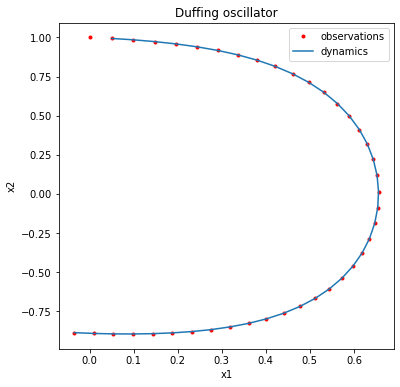

In [5]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def duffing(x, t, gamma=0.1, kappa=1, epsilon=5):
    return [
            x[1],
            -gamma * x[1] - kappa * x[0] - epsilon * x[0] ** 3
            ]

gamma=0.1
kappa=1
epsilon=5

####################### GENERATE DATA #######################

# Simulate dynamics

t0, te = 0, 2 # start and end
dt = 0.05  # time step
n_times = int(np.floor(te-t0)/dt + 1) #Number of time instances
n_states = 2 #Number of state variables
t_span = np.linspace(t0, te, n_times)
x0 = [0, 1]
X = odeint(duffing, x0, t_span)

x1 = X[:,0]
x2 = X[:,1]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = x2
dX[:,1] =  -gamma * x2 - kappa * x1 - epsilon * x1 ** 3

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Duffing oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

In [6]:
model = SRSplineIdentification(Y,t,4,4)

Instructions for updating:
Do not call `graph_parents`.


In [7]:
model.train_step()

NameError: name 'tape' is not defined

In [9]:
H = tf.random.uniform((5,5))

In [11]:
DH = tf.reshape(tf.linalg.diag_part(H),(-1,1))

In [13]:
h = tf.random.uniform((5,1))

g = tf.random.uniform((5,1))

In [14]:
v = DH * h - g

In [18]:
tf.transpose(h)@v

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.65856165]], dtype=float32)>

In [19]:
tf.reduce_sum(h*v)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.6585617>